# Exponential infection model with a lockdown control using indirect and direct methods 

Sandra Montes (@slmontes), 2025-04-07

## Introduction

This example explores the optimal control of an SIR (Susceptible-Infected-Recovered) model using a time-varying intervention that reduces the infection rate. To simplify the dynamics, it is assumed that the susceptible population remains approximately constant throughout the time horizon, i.e., `S ≈ N`. This assumption is valid during the early stages of an outbreak when the number of infections is still relatively small compared to the total population.

Under this simplification, the model focuses on a single compartment of infected individuals (`I`). The intervention is modelled as a time-dependent control variable `υ(t)` that reduces the effective transmission rate by a factor of `1 - υ(t)`, where `υ(t) ∈ [0, 1]` represents the intensity of the applied control (e.g., social distancing or lockdown measures).

The model is described by:

$$
\begin{aligned}
\dfrac{\mathrm{d}I}{\mathrm{dt}} &= (\beta * (1 - υ(t)) * N - \gamma) * I
\end{aligned}
$$

Here, `β` is the transmission rate, `γ` is the recovery rate, and `N` is the total population.

In this example, the goal is to minimise the number of infected individuals over time. To determine whether an optimal policy can be derived both analytically and numerically, we apply Pontryagin’s Maximum Principle (PMP) using Euler discretisation to establish the optimality conditions and perform the numerical simulations using the forward-backwards method. We then compare this analytical solution with a numerical optimisation approach implemented in JuMP.jl, utilising the IPOPT solver. 

## Optimal control formulation 

Objective functional:

$$
\begin{aligned}
J = \int_0^{T_f} \left[ A I(t) + B υ(t)^2 \right] dt
\end{aligned}
$$

where:
- A: weight for the number of infected individuals  
- B: weight for the control effort quadratically 
- υ: control variable $0 \leq υ(t) \leq υ_{max}$


Hamiltonian:

$$
\begin{aligned}
\mathcal{H}(I, υ, \lambda) = A I + B υ^2 + \lambda \cdot \left( \left( \beta (1 - υ) N - \gamma \right) I \right)
\end{aligned}
$$

where $\lambda$ is the adjoint variable associated with the state I

Adjoint equation:

$$
\begin{aligned}
\frac{d\lambda}{dt} = -\frac{\partial \mathcal{H}}{\partial I} = -A - \lambda \left( \beta (1 - υ) N - \gamma \right)
\end{aligned}
$$

Optimality condition:

$$
\begin{aligned}
\frac{\partial \mathcal{H}}{\partial υ} = 2 B υ - \lambda \cdot \beta N I = 0
\end{aligned}
$$

we then solve for υ

$$
\begin{aligned}
υ^* = \frac{\lambda \cdot \beta N I}{2 B}
\end{aligned}
$$

and add the control bounds

$$
\begin{aligned}
υ^*(t) = \min\left( \max\left( 0, \frac{\lambda(t) \cdot \beta N I(t)}{2 B} \right), υ_{max} \right)
\end{aligned}
$$

## Running the model without intervention

## Libraries

In [1]:
using OrdinaryDiffEq
using JuMP
using Ipopt
using Plots;

Model

In [2]:
function infection!(du,u,p,t)
    I = u[1]
    (β, γ, υ, N) = p
    @inbounds begin
        du[1] = (β * (1 - υ) * N - γ) * I
    end
    nothing
end;

Parameters

In [3]:
u0 = [0.1]; #I
p = [0.5, 0.25, 0.0, 0.9]; # β, γ, υ, N
t0 = 0.0
tf = 100
dt = 0.1
ts = collect(t0:dt:tf)
alg = Tsit5();

Solve using ODEProblem

In [4]:
prob_base = ODEProblem(infection!, u0, (t0, tf), p)
sol_base = solve(prob_base, alg, saveat=ts);

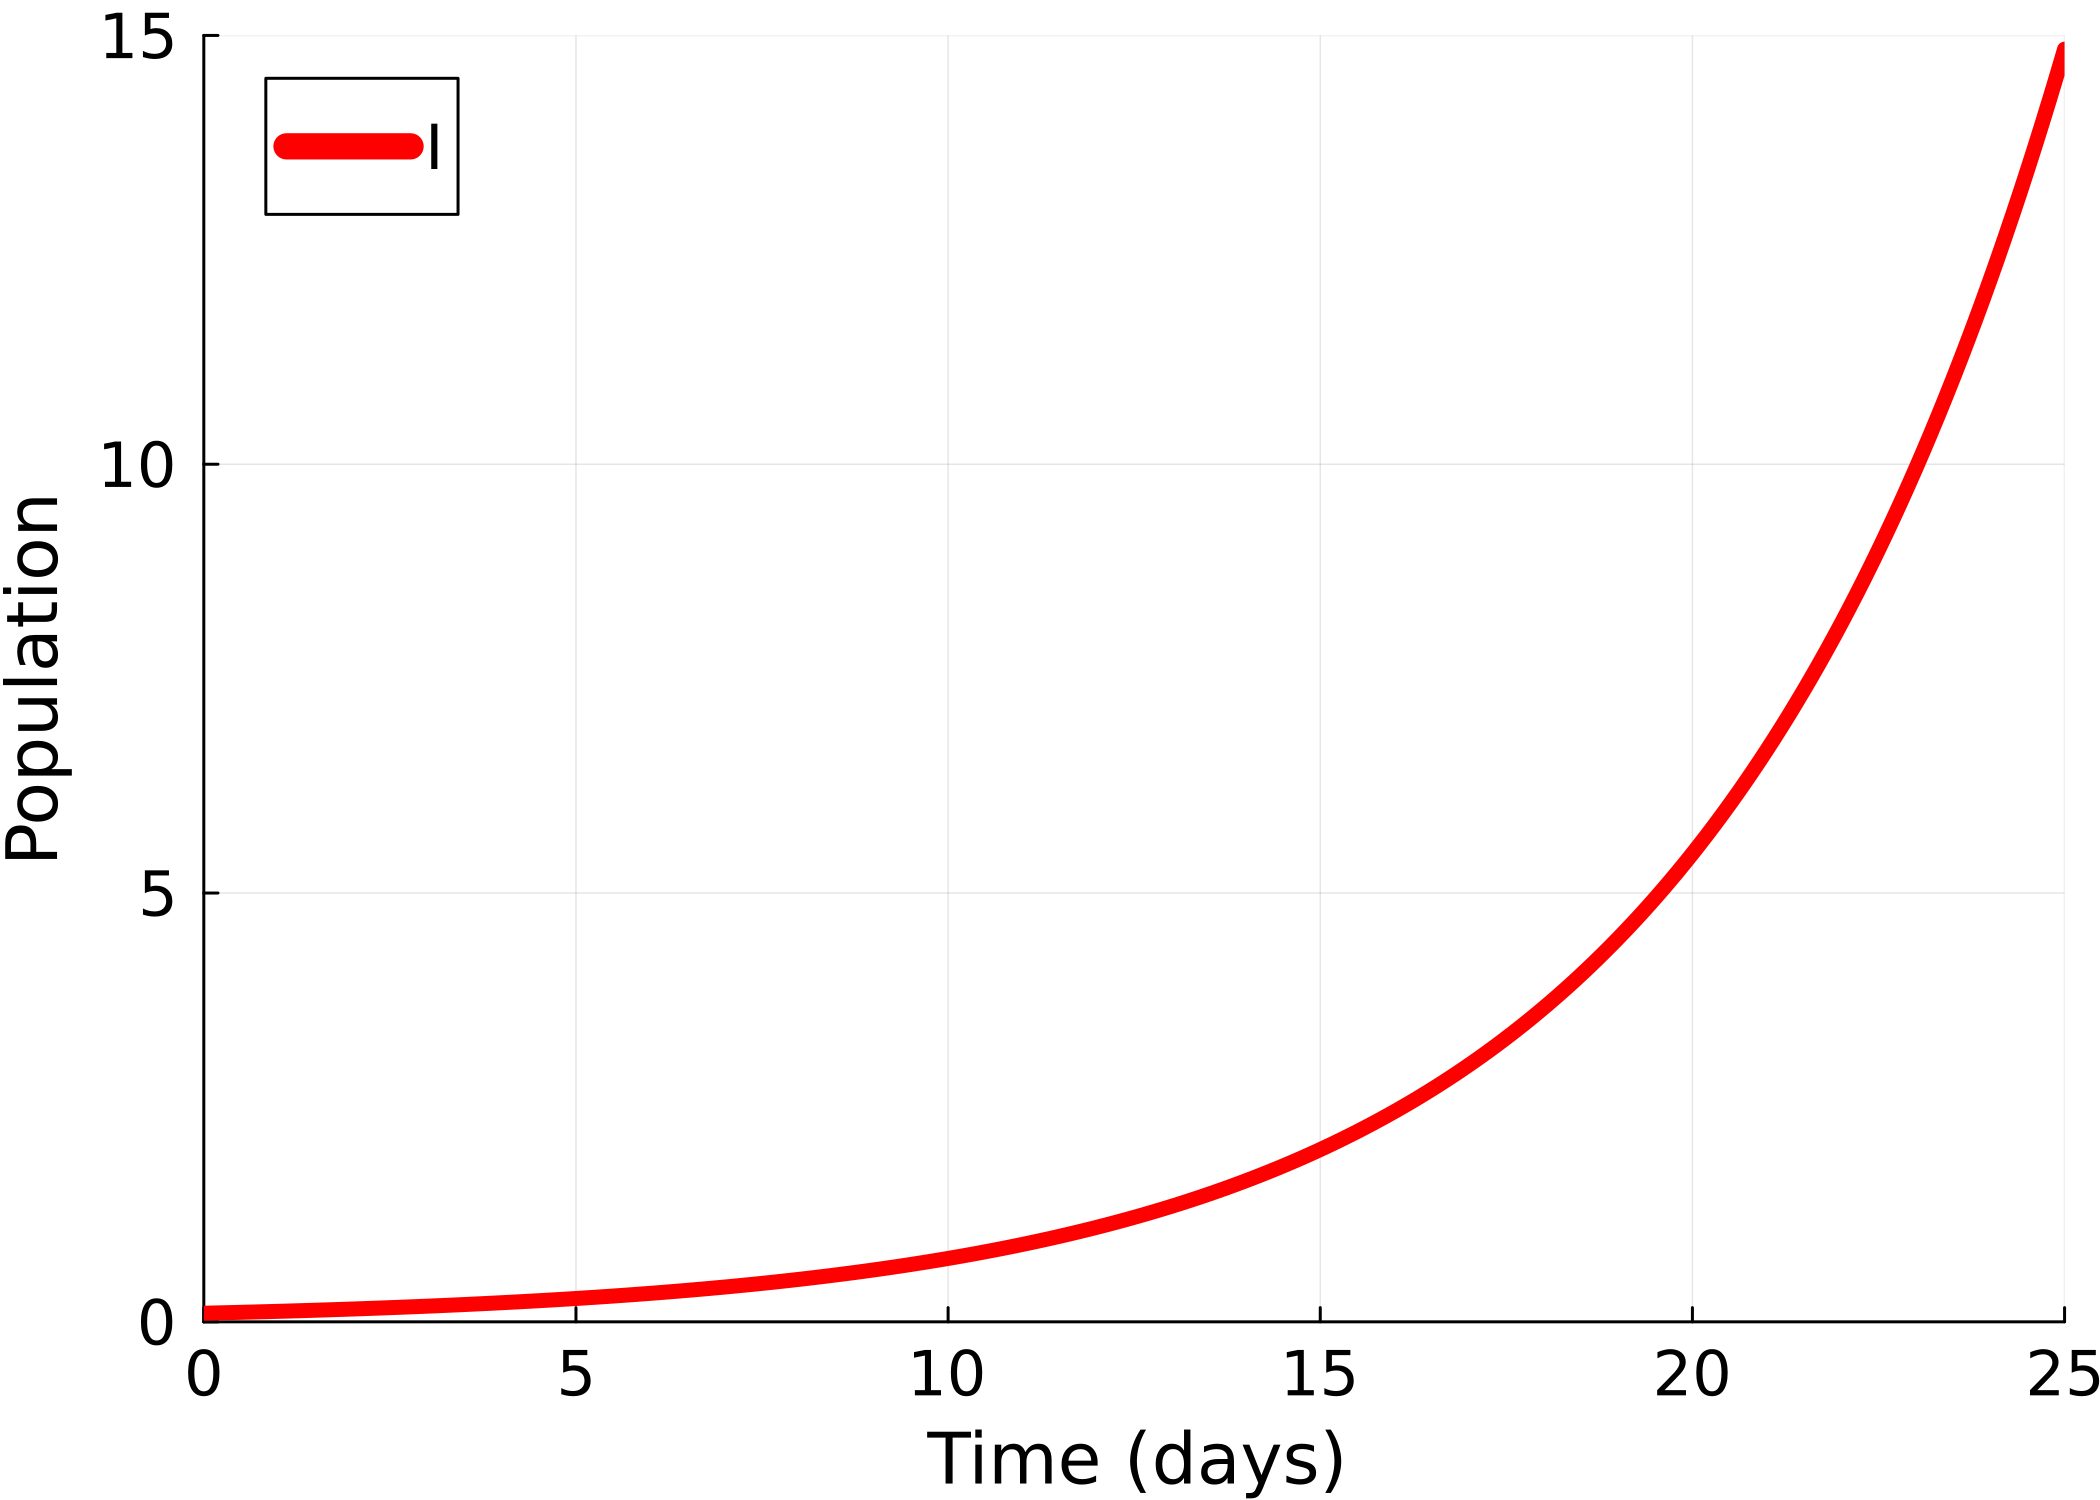

In [5]:
plot(sol_base,
     xlim = [0, 25],
     ylim = [0, 15],
     linewidth=5, color=:red,
     xtickfontsize=14,ytickfontsize=14,
     xguidefontsize=16,yguidefontsize=16,
     label="I", legendfontsize=14,
     xlabel="Time (days)",
     ylabel="Population", size=(700,500), dpi=300)
     # savefig("baseline_expinf.png")

In [6]:
fianl_I_base = sol_base[end][1]
println("Without control the final number of infectees is: ", 
        round(fianl_I_base, digits=-5)," at t=", tf)

Without control the final number of infectees is: 4.85e7 at t=100


# Numerical simulations using the analytical formulation from PMP and forward-backward sweep

Forward-Backward Sweep Method

In [7]:
function exp_sir_forward_backward(I₀, β, γ, υ_max, N, tf, dt, A=1.0, B=1.0; tol=1e-6)
    T = Int(tf / dt)
    t = range(0, tf, length=T+1)

    I = zeros(T+1); I[1] = I₀
    λI = zeros(T+1)
    υ = zeros(T+1)

    δ = 1e-3
    sweep = 0
    test = -1.0
    max_iter = 10000

    while test < 0 && sweep < max_iter
        sweep += 1

        I_old = copy(I)
        υ_old = copy(υ)
        λI_old = copy(λI)

        # FORWARD SWEEP
        for k in 1:T
            infection = dt * β * (1 - υ[k]) * N * I[k]
            recovery  = dt * γ * I[k]
            I[k+1] = I[k] + infection - recovery
        end

        # BACKWARD SWEEP
        λI[T+1] = 0.0
        for k in T:-1:1
            λI[k] = λI[k+1] + dt * (-A + λI[k+1] * (β * (1 - υ[k]) * N - γ))
        end

        # CONTROL UPDATE
        temp = -λI.*β.*N.*I./(2 .* B)
        υ_new = clamp.(temp, 0.0, υ_max)
        υ .= 0.5 .* (υ_new .+ υ_old)

        test = minimum([
            δ * sum(abs.(υ)) - sum(abs.(υ .- υ_old)),
            δ * sum(abs.(I)) - sum(abs.(I .- I_old)),
            δ * sum(abs.(λI)) - sum(abs.(λI .- λI_old))
        ])
    end

    if test ≥ 0
        println("Converged in $sweep sweeps.")
    else
        println("Did not converge in $sweep sweeps.")
    end

    # Final forward pass to get the optimal I under optimal υ
    I_opt = zeros(T+1)
    I_opt[1] = I₀
    for k in 1:T
        infection = dt * β * (1 - υ[k]) * N * I_opt[k]
        recovery  = dt * γ * I_opt[k]
        I_opt[k+1] = I_opt[k] + infection - recovery
    end

    return (; t, I=I_opt, υ, λI)
end


exp_sir_forward_backward (generic function with 3 methods)

Parameters

In [8]:
p2 = copy(p)
υ_max = p2[3] = 0.5   #Set υ to 0.5
β = p2[1]
γ = p2[2]
N = p2[4]
A = 10
B = 0.01
I0 = u0[1];

In [9]:
res = exp_sir_forward_backward(I0, β, γ, υ_max, N, tf, dt, A, B)

Converged in 14 sweeps.


(t = 0.0:0.1:100.0, I = [0.1, 0.09975013732910157, 0.09950089897174622, 0.09925228336800745, 0.09900428896185647, 0.09875691420115236, 0.09851015753763248, 0.0982640174269027, 0.09801849232842773, 0.09777358070552154  …  0.008380708698505991, 0.008359768435911687, 0.008338880495216793, 0.008318044745688416, 0.008297261056920312, 0.008276529298832075, 0.008255849341668321, 0.008235221055997877, 0.008260890931513616, 0.008356005254263348], υ = [0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875  …  0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.499969482421875, 0.3751759118514946, 0.18858201578102318, 0.0], λI = [-367.5826563867217, -367.50039801176143, -367.4179337025231, -367.3352629434491, -367.25238521769114, -367.1693000071071, -367.08600679225754, -367.00250505240274, -366.91879

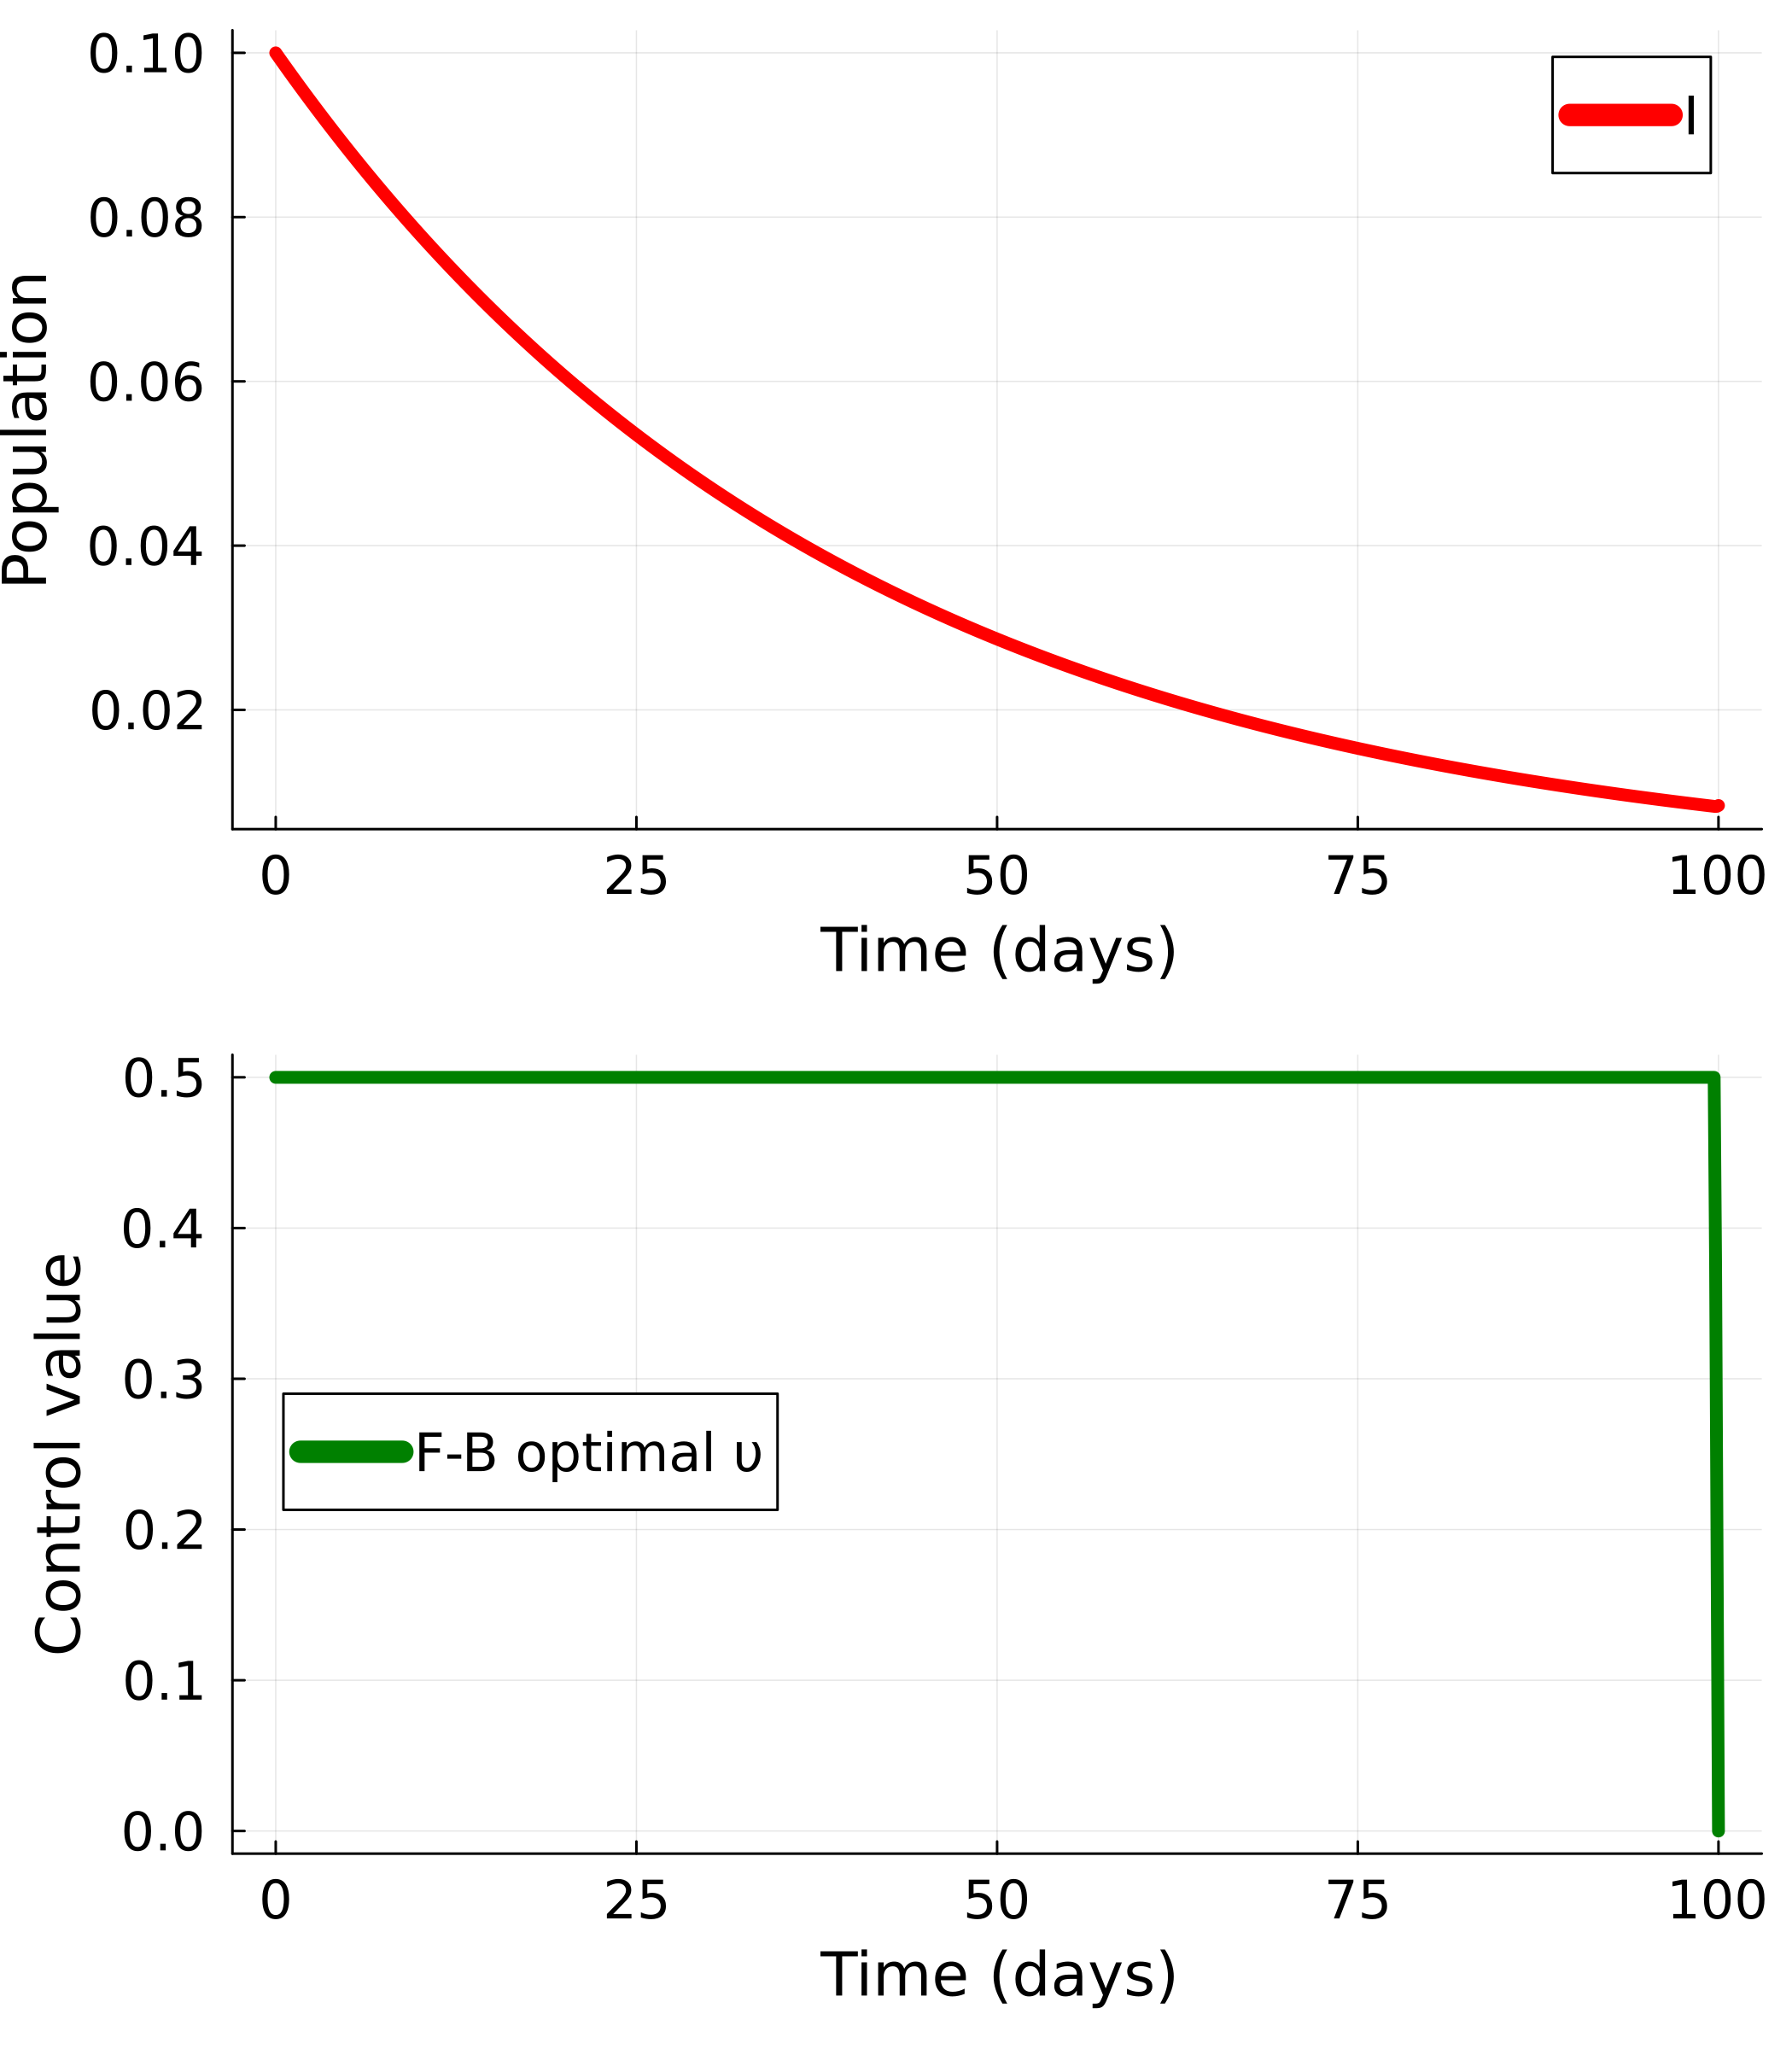

In [10]:
t = res.t
u_fb_opt = res.υ
I_fb_opt = res.I

p1 = plot(t, I_fb_opt, 
     linewidth=5, color=:red,
     xtickfontsize=14, ytickfontsize=14,
     xguidefontsize=16, yguidefontsize=16,
     label="I", legendfontsize=14,
     xlabel="Time (days)",
     ylabel="Population")

p2 = plot(t, u_fb_opt, 
     linewidth=5, color=:green,
     xtickfontsize=14, ytickfontsize=14,
     xguidefontsize=16, yguidefontsize=16,
     label="F-B optimal υ", legendfontsize=14,
     xlabel="Time (days)",
     ylabel="Control value",
     legend=:left)

plot(p1, p2, layout=(2,1), size=(700,800), dpi=300)
# savefig("FB_expinf.png")


In [11]:
fianl_I_fb = I_fb_opt[end][1]
println("Applying optimal control (Forward-Backward method) 
the final number of infectees is: ", 
round(fianl_I_fb, digits=3)," at t=", tf)

Applying optimal control (Forward-Backward method) 
the final number of infectees is: 0.008 at t=100


# Solving optimal problem using JuMP

Parameters (same)

In [12]:
T = Int(tf/dt);

Model setup

In [13]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "max_iter", 1000)

Variables

In [14]:
@variable(model, 0 <= I[1:(T+1)] <= 1)
@variable(model, 0 <= υ[1:(T+1)] <= υ_max);

Model expressions

In [15]:
@expressions(model, begin
        infection[t in 1:T], (1 - υ[t]) * β * N * I[t] * dt  # Linear approximation of infection rate
        recovery[t in 1:T], γ * dt * I[t] # Recoveries at each time step
    end);

Model constraints described by the expressions

In [16]:
@constraints(model, begin
    I[1]==I0
    [t=1:T], I[t+1] == I[t] + infection[t] - recovery[t]
end);

Minimise the objective function

In [17]:
@objective(model, Min, sum(dt * (A * I[t] + B * υ[t]^2) for t in 1:T+1));

Set model to silent to prevent printing full optimisation output

In [18]:
silent = true
if silent
    set_silent(model)
end
if !silent
    set_optimizer_attribute(model, "output_file", "JuMP_lockdown.txt")
    set_optimizer_attribute(model, "print_timing_statistics", "yes")
end
optimize!(model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [19]:
termination_status(model)

LOCALLY_SOLVED::TerminationStatusCode = 4

In [20]:
I_opt = value.(I)
υ_opt = value.(υ);

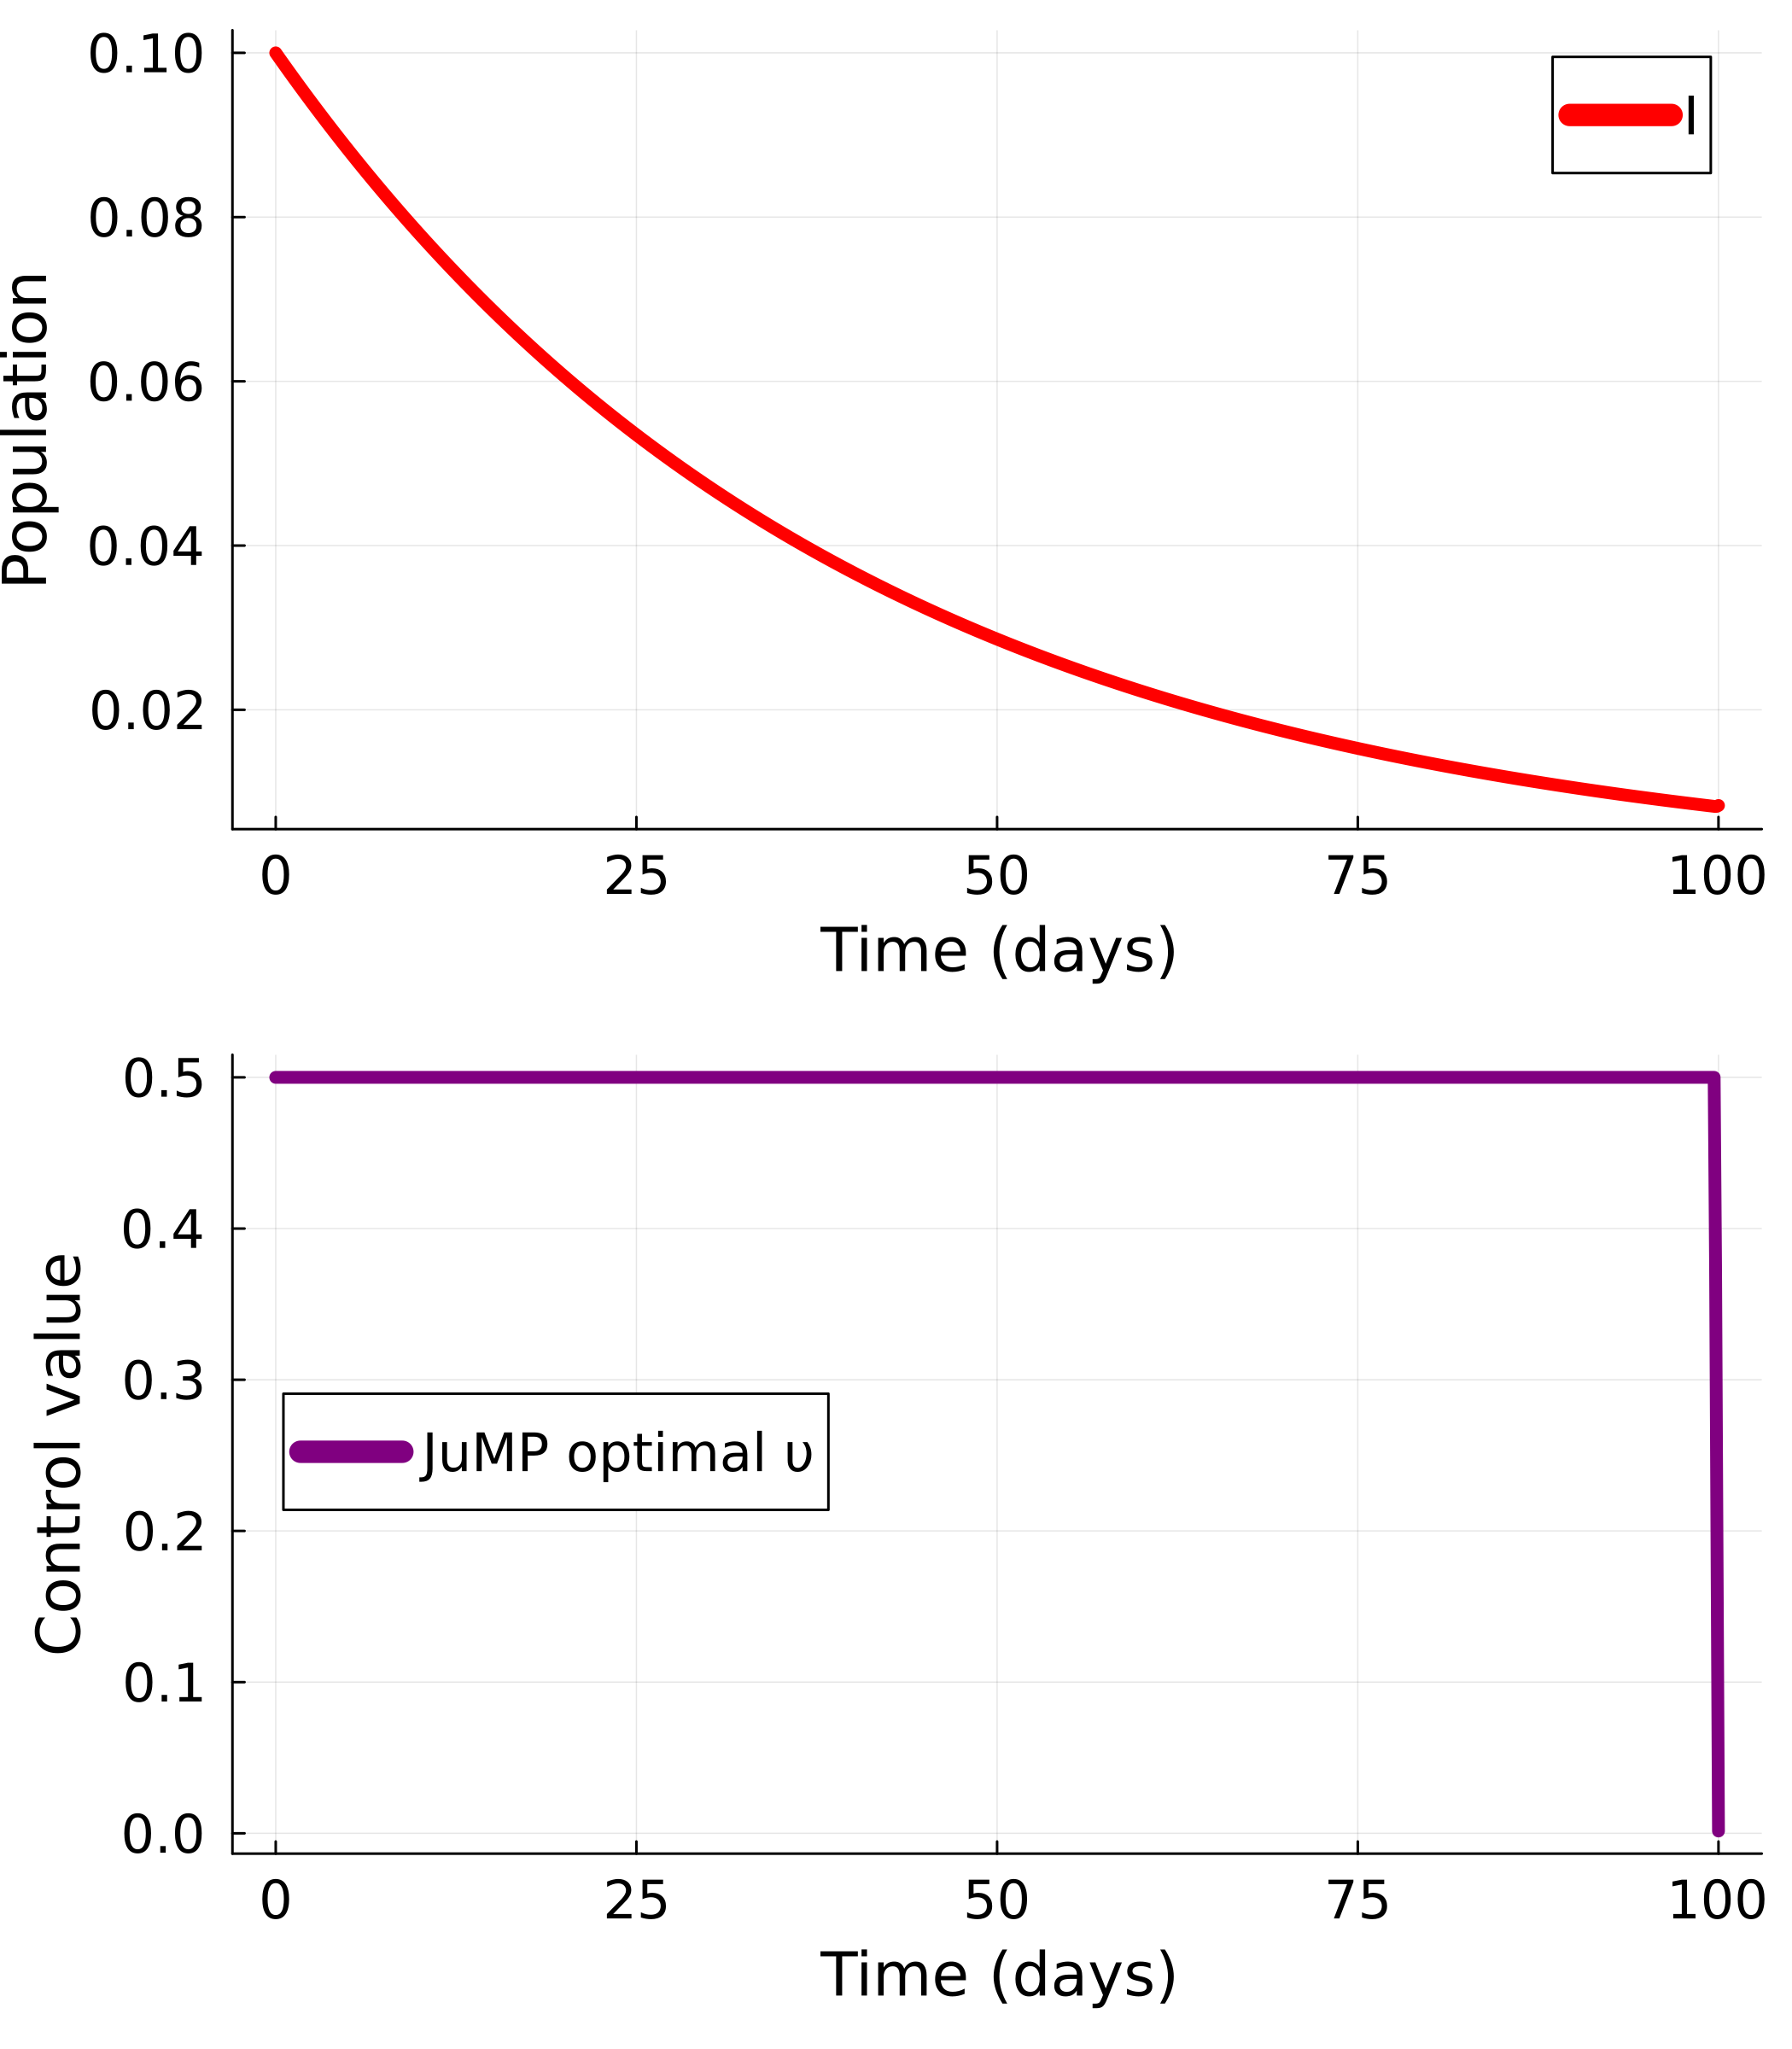

In [21]:
p3 = plot(t, I_opt, 
     linewidth=5, color=:red,
     xtickfontsize=14, ytickfontsize=14,
     xguidefontsize=16, yguidefontsize=16,
     label="I", legendfontsize=14,
     xlabel="Time (days)",
     ylabel="Population")

p4 = plot(t, υ_opt, 
     linewidth=5, color=:purple,
     xtickfontsize=14, ytickfontsize=14,
     xguidefontsize=16, yguidefontsize=16,
     label="JuMP optimal υ", legendfontsize=14,
     xlabel="Time (days)",
     ylabel="Control value",
     legend=:left)

plot(p3, p4, layout=(2,1), size=(700,800), dpi=300)
# savefig("JuMP_expinf.png")

In [22]:
fianl_I_jump = I_opt[end]
println("Applying optimal control (JuMP) 
the final number of infectees is: ", 
round(fianl_I_jump, digits=3)," at t=", tf)

Applying optimal control (JuMP) 
the final number of infectees is: 0.008 at t=100
